# Proyecto 7

Área: Medio Ambiente

Descripción: Deberán **modelar** el consumo de agua en una ciudad durante varios meses o años, utilizando diferentes variables. El objetivo es **identificar** patrones de uso, **predecir** la demanda futura y **evaluar** posibles escenarios de escasez mediante **simulaciones**.


---

### Librerias importadas

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')

### Funciones utilizadas

Funciones utilizadas en la preparación de datos.

In [4]:
def normalizar(archivo_csv):
    df_temp= pd.read_csv(archivo_csv)
    scaler = MinMaxScaler()
    df_normalizado = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns)
    return df_normalizado

In [5]:
def FirstNonNull(row):
    count=0
    for col in row:
        if col==False: return count
        else: count = count+1
    return count

def LastNonNull(row):
    count=0
    flag=-1
    for col in row:
        if col==False:
            flag=count
            count=count+1
        else: count=count+1
    return flag
def Setzero(x):
    if x<0: return 0
    else: return x

Funciones utilizadas para la imputación

In [6]:
def KnnImputeSimple(sample, x, k):
    ## Mask the columns with NaN value (not to compare)
    x_mask = x.notnull().tolist()
    x_mask_toggled = x.isnull().tolist()
    sample_masked = sample.iloc[:,x_mask]
    x_masked = x[x_mask]
    
    ## Extent to which column comparison is carried out. Here 6 columns (months) before and after the the column in question
    comp_size = 6
    i = x_mask_toggled.index(True)
    ## Handle when there are less than 4 columns to look at before or after the column in question
    i = max(comp_size, min(i, 84-1-comp_size))
    x_masked = x_masked[i-comp_size:i+comp_size].values
    sample_masked = sample_masked.iloc[:,i-comp_size:i+comp_size]
    
    ## I use kd_tree algorithm here.
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
    nbrs.fit(sample_masked)
    n_ones = nbrs.kneighbors([x_masked])
    
    ## Find k nearest ones and average the predicted values to return
    value = []
    for n in range(x.isnull().sum()):
        temp=[]
        for j in range(k):
            temp.append(sample.iloc[n_ones[1][0][j]][x_mask_toggled][n])
        value.append(np.sum(temp)/k)

    return value

def KnnImputeInPlace(sample, itrp, k):
    fn = itrp['FirstNonNull']
    ln = itrp['LastNonNull']
    serv = itrp[int(fn):int(ln)+1]
    

    index = serv[serv.isnull()].index.tolist()
    itrp_imputed = itrp
    for i in range(len(index)):
        idx = index.copy()
        idx.pop(i)
        imp = KnnImputeSimple(sample.iloc[:,int(fn):int(ln)+1].drop(sample[idx],axis=1), serv.drop(idx), k)
        itrp_imputed.iloc[i] = imp[0]
    
    return itrp_imputed

Funciones para calcular estadisticas, diferenciar una serie de tiempo y graficar los resultados:

<Aquí deberia ir separado cada función con una breve explicación de lo que hace>

In [7]:
def diferenciar(serie):
    df_diferenciado = serie.copy()
    df_diferenciado['Consumo'] = serie['Consumo'].diff(periods=12)
    df_diferenciado = df_diferenciado.dropna()
    return df_diferenciado

def graficar(serie):
    df_temp = serie.copy()
    df_temp.plot()

def calcular_estadisticas(serie):
    df_estadisticas = serie.copy()
    df_estadisticas['Año'] = df_estadisticas.index.year
    estadisticas = df_estadisticas.groupby('Año')['Consumo'].agg([
    'mean',       # media
    'std',        # desviación estándar
    ])
    display(estadisticas)
    estadisticas[['mean', 'std']].plot(title='Media y desviación estándar por año')
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show() 


Funciones para calcular reazagos utilizados para la ACF (función de autocorrelación):

<Aquí deberia ir separado cada función con una breve explicación de lo que hace>

In [8]:

def numerador_rk(serie, promedio,k):
    T = len(serie)
    suma = 0
    
    for t in range(k+1, T):
        suma += (serie[t] - promedio) * (serie[t - k] - promedio)
    return suma


def denominador_rk(serie, promedio):
    T = len(serie)
    suma = 0

    for t in range(1, T):
        suma += (serie[t] - promedio)**2
    return suma

def coeficientes_rk(serie, n_rezagos):
    promedio = serie["Consumo"].sum() / len(serie)
    
    denominador = denominador_rk(serie["Consumo"].values, promedio)

    r = np.empty(n_rezagos, dtype=float)
    for k in range (0 , n_rezagos):
        numerador = numerador_rk(serie["Consumo"].values, promedio, k)
        r[k] = numerador/denominador

    graficar_coeficientes_rk(serie, r)
    return r

def graficar_coeficientes_rk(serie, rk):
    n = len(serie)
    confianza = 1.96/ (n**(1/2))
    k_vals = np.arange(len(rk)) 

    plt.figure(figsize=(10, 5))
    plt.stem(k_vals, rk, basefmt=" ")
    plt.axhline(0, color='black', linewidth=1)
    plt.axhline(y=confianza, color='red', linestyle='--', label=f'+{confianza:.3f}')
    plt.axhline(y=-confianza, color='red', linestyle='--', label=f'-{confianza:.3f}')
    plt.title("Correlograma Muestral (ACF)")
    plt.xlabel("Rezago (k)")
    plt.ylabel("rk")
    plt.xticks(k_vals)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Funciones para la parte de PACF

<>

In [67]:

def plot_pacf(pacf_vals, n_obs, conf_level=0.95):
    """
    Grafica la PACF calculada manualmente.

    pacf_vals : array-like
        Valores de la PACF (no incluye lag 0)
    n_obs : int
        Número de observaciones de la serie usada (sirve para calcular intervalo de confianza)
    conf_level : float
        Nivel de confianza (por defecto 95%)
    """
    lags = np.arange(1, len(pacf_vals)+1)
    z = 1.96 if conf_level == 0.95 else {
        0.90: 1.645,
        0.99: 2.576
    }.get(conf_level, 1.96)

    conf_interval = z / np.sqrt(n_obs)

    plt.figure(figsize=(10, 5))
    plt.stem(lags, pacf_vals)
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axhline(y=conf_interval, color='red', linestyle='--', label=f'±{conf_interval:.3f}')
    plt.axhline(y=-conf_interval, color='red', linestyle='--')
    plt.title("PACF (calculada manualmente)")
    plt.xlabel("Rezago (lag)")
    plt.ylabel("PACF")
    plt.legend()
    plt.grid(True)
    plt.show()


#def levinson_durbin(r, nlags):
#    """
#    r : array-like
#        Coeficientes de autocorrelación (r[0] debe ser 1)
#    nlags : int
#        Número de lags para calcular la PACF (incluye lag 0)
#    """
#    pacf = np.zeros(nlags + 1)
#    phi = np.zeros((nlags, nlags)) 
#    sigma2 = np.zeros(nlags)
#
#    pacf[0] = 1.0  
#
#
#   phi[0, 0] = pacf[1] = r[1]
#    sigma2[0] = 1 - phi[0, 0] ** 2
#
#   for k in range(1, nlags):
#        sum_phi_r = sum(phi[k-1, j] * r[k - j] for j in range(k))
#        phi[k, k] = (r[k+1] - sum_phi_r) / sigma2[k-1]
#
#
#
#        for j in range(k):
#            phi[k, j] = phi[k-1, j] - phi[k, k] * phi[k-1, k-j-1]
#
#
#        sigma2[k] = sigma2[k-1] * (1 - phi[k, k] ** 2)
#
#        pacf[k+1] = phi[k, k]  
#    plot_pacf(pacf, len(pacf))
#    return pacf, phi


def sumatoria_levinson_durbin(r, phi, k):
    resultado = 0
    for j in range(k):
        resultado += phi[k-1, j] * r[k-j]
    return resultado

def levinson_durbin(r):
    nlags = len(r) -1
    pacf = np.zeros(nlags + 1)
    phi = np.zeros((nlags, nlags))
    sigma = np.zeros(nlags)
    pacf[0] = 1

    phi[0,0] = pacf[1] = r[1]
    sigma[0] = 1 - phi[0,0]**2
    
    for k in range(1, nlags):
        sumatoria = sumatoria_levinson_durbin(r, phi, k)
        phi[k,k] = (r[k+1] - sumatoria)/sigma[k-1]

        for j in range(k):
            phi[k,j] = phi[k-1,j] - phi[k,k] * phi[k-1, k-j-1]
        sigma[k] = sigma[k-1] * (1 - phi[k,k]**2)

        pacf[k+1] = phi[k,k]
    plot_pacf(pacf, len(pacf))
    return pacf, phi

Funciones utilizadas para el modelado

In [82]:
def modelo_ar1(z_serie, phi1):
    z = z_serie.values
    z_hat = []

    for t in range(2, len(z)):
        pred = phi1 * z[t]
        z_hat.append(pred)

    fechas = z_serie.index[2:]
    return pd.Series(z_hat, index=fechas, name='Modelo AR(1)')

def modelo_ar2(z_serie, phi1, phi2):
    z = z_serie.values
    z_hat = []

    for t in range(2, len(z)):
        pred = phi1 * z[t] + phi2 * z[t-1]
        z_hat.append(pred)

    fechas = z_serie.index[2:]
    return pd.Series(z_hat, index=fechas, name='Modelo AR(2)')

def modelo_ar3(z_serie, phi1, phi2, phi3):
    z = z_serie.values
    z_hat = []

    for t in range(2, len(z)):
        pred = phi1 * z[t] + phi2 * z[t-1] + phi3 * z[t-2]
        z_hat.append(pred)

    fechas = z_serie.index[2:]
    return pd.Series(z_hat, index=fechas, name='Modelo AR(3)')

Funciones para el pronóstico
<>

In [ ]:
def pronosticar_ar1(df_dif, df_original, phi_1, pasos=12):
    """
    Pronostica múltiples pasos adelante con un modelo AR(2).
    Devuelve DataFrame con la serie extendida.
    """
    z_hist = df_dif['Consumo'].copy()
    y_hist = df_original['Consumo'].copy()
    z_pred_list = []
    y_pred_list = []

    for i in range(pasos):
        z_t   = z_hist.iloc[-1]
        z_t_1 = z_hist.iloc[-2]
        z_next = phi_1 * z_t
        z_pred_list.append(z_next)
        z_hist = pd.concat([z_hist, pd.Series([z_next])], ignore_index=True)

        y_t    = y_hist.iloc[-1]
        y_t_12 = y_hist.iloc[-12]
        y_t_13 = y_hist.iloc[-13]
        y_next = z_next + y_t + y_t_12 - y_t_13
        y_pred_list.append(y_next)
        y_hist = pd.concat([y_hist, pd.Series([y_next])], ignore_index=True)

    # Fechas nuevas
    last_date = df_original.index[-1]
    fechas = [last_date + pd.DateOffset(months=i+1) for i in range(pasos)]

    # Crear DataFrame con predicciones
    df_pronostico = df_original.copy()
    df_pred = pd.DataFrame({'Consumo': y_pred_list}, index=fechas)
    df_pronostico = pd.concat([df_pronostico, df_pred])

    return df_pronostico, y_pred_list


---

## Análisis del dataset

Analizamos las columnas del data set, de esto posteriormente nos interezará conocer cuantos valores NaN (Not a Number) tenemos y en que columnas.

In [12]:
aguah = pd.read_csv("AguaH.csv")
aguah

USO2013                     TU   DC                M      UL  \
0           H3        DOMESTICO MEDIO  0.5       MSDELAUNET   197.0   
1           H3        DOMESTICO MEDIO  0.5       MSDELAUNET   307.0   
2           H3  DOMESTICO RESIDENCIAL  0.5       MSDELAUNET   179.0   
3           H3        DOMESTICO MEDIO  0.5  CICASA MMD-15 S   852.0   
4           H3  DOMESTICO RESIDENCIAL  0.5              NaN     NaN   
...        ...                    ...  ...              ...     ...   
178592     RHC              COMERCIAL  3.0            ADCOM  6614.0   
178593      MX              COMERCIAL  3.0            ADCOM  6614.0   
178594     RHC              COMERCIAL  3.0            ADCOM  6614.0   
178595      MX              COMERCIAL  3.0            ADCOM  6614.0   
178596      MX              COMERCIAL  3.0            ADCOM  6614.0   

        f.1_ENE_09  f.1_FEB_09  f.1_MAR_09  f.1_ABR_09  f.1_MAY_09  ...  \
0             20.0        20.0        20.0        20.0        20.0  ...   
1              NaN        30.0        30.0        30.0        30.0  ...   
2              NaN         NaN         NaN         NaN         NaN  ...   
3              NaN         NaN         NaN         NaN         NaN  ...   
4             20.0        20.0        20.0        20.0        20.0  ...   
...            ...         ...         ...         ...         ...  ...   
178592      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178593      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178594      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178595      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178596      2574.0      1685.0      1141.0      1316.0      1521.0  ...   

        f.1_MAR_15  f.1_ABR_15  f.1_MAY_15  f.1_JUN_15  f.1_JUL_15  \
0              2.0         1.0         2.0         1.0         7.0   
1             11.0        13.0        16.0        14.0        15.0   
2              6.0         9.0         7.0         8.0         8.0   
3             17.0        20.0        16.0        16.0        18.0   
4             27.0        27.0        27.0        28.0        28.0   
...            ...         ...         ...         ...         ...   
178592      4924.0      4346.0      5118.0      4755.0      6444.0   
178593      4924.0      4346.0      5118.0      4755.0      6444.0   
178594      4924.0      4346.0      5118.0      4755.0      6444.0   
178595      4924.0      4346.0      5118.0      4755.0      6444.0   
178596      4924.0      4346.0      5118.0      4755.0      6444.0   

        f.1_AGO_15  f.1_SEP_15  f.1_OCT_15  f.1_NOV_15  f.1_DIC_15  
0              7.0        42.0        27.0        22.0        21.0  
1             16.0        13.0        17.0        17.0        11.0  
2             10.0        12.0         9.0         6.0         3.0  
3             18.0        17.0        17.0        18.0         9.0  
4             31.0        27.0        27.0        27.0        24.0  
...            ...         ...         ...         ...         ...  
178592      5783.0      6476.0      3123.0      4756.0      4435.0  
178593      5783.0      6476.0      3123.0      4756.0      4435.0  
178594      5783.0      6476.0      3123.0      4756.0      4435.0  
178595      5783.0      6476.0      3123.0      4756.0      4435.0  
178596      5783.0      6476.0      3123.0      4756.0      4435.0  

[178597 rows x 89 columns]

In [13]:
lookup = {'ENE':'01',
          'FEB':'02',
          'MAR':'03',
          'ABR':'04',
          'MAY':'05',
          'JUN':'06',
          'JUL':'07',
          'AGO':'08',
          'SEP':'09',
          'OCT':'10',
          'NOV':'11',
          'DIC':'12'
          }
clist=[]
for col in aguah.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]])

columns = ['TIPO USO','TIPO USUARIO','DIAMETRO_TUBERIA','PROVEEDOR','ENE16']+clist
aguah.columns=columns
aguah.head()

TIPO USO           TIPO USUARIO  DIAMETRO_TUBERIA        PROVEEDOR  ENE16  \
0       H3        DOMESTICO MEDIO               0.5       MSDELAUNET  197.0   
1       H3        DOMESTICO MEDIO               0.5       MSDELAUNET  307.0   
2       H3  DOMESTICO RESIDENCIAL               0.5       MSDELAUNET  179.0   
3       H3        DOMESTICO MEDIO               0.5  CICASA MMD-15 S  852.0   
4       H3  DOMESTICO RESIDENCIAL               0.5              NaN    NaN   

   2009-01  2009-02  2009-03  2009-04  2009-05  ...  2015-03  2015-04  \
0     20.0     20.0     20.0     20.0     20.0  ...      2.0      1.0   
1      NaN     30.0     30.0     30.0     30.0  ...     11.0     13.0   
2      NaN      NaN      NaN      NaN      NaN  ...      6.0      9.0   
3      NaN      NaN      NaN      NaN      NaN  ...     17.0     20.0   
4     20.0     20.0     20.0     20.0     20.0  ...     27.0     27.0   

   2015-05  2015-06  2015-07  2015-08  2015-09  2015-10  2015-11  2015-12  
0      2.0      1.0      7.0      7.0     42.0     27.0     22.0     21.0  
1     16.0     14.0     15.0     16.0     13.0     17.0     17.0     11.0  
2      7.0      8.0      8.0     10.0     12.0      9.0      6.0      3.0  
3     16.0     16.0     18.0     18.0     17.0     17.0     18.0      9.0  
4     27.0     28.0     28.0     31.0     27.0     27.0     27.0     24.0  

[5 rows x 89 columns]

* **Análisis de datos nulos**

Identificamos los valores diferentes de NaN, mismos que nos serviran para imputar los datos NaN posteriormente:

Proporción de valores distintos de NaN : 79.06%


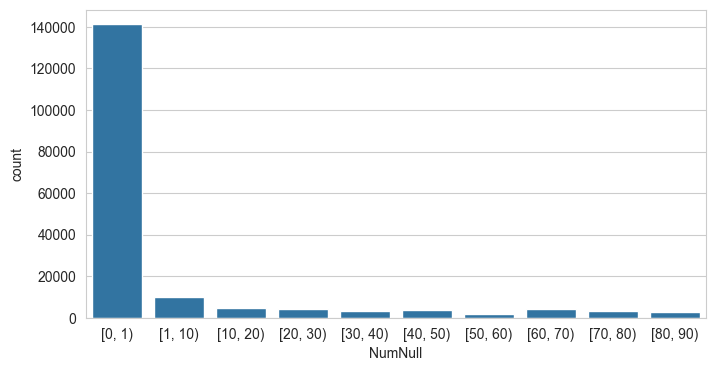

In [14]:
cons = aguah.iloc[0:, 5:]
cons['NumNull'] = cons.isnull().sum(axis=1)
print('Proporción de valores distintos de NaN : {:.2f}%'.format(len(cons[cons.NumNull==0])/len(cons)*100))
bins = [0,1,10,20,30,40,50,60,70,80,90]
cut = pd.cut(cons.NumNull, bins=bins, include_lowest=True, right=False)
fig, axis1 = plt.subplots(1,figsize=(8,4))
sns.countplot(x=cut, data=cut.to_frame(), ax=axis1)
plt.show()

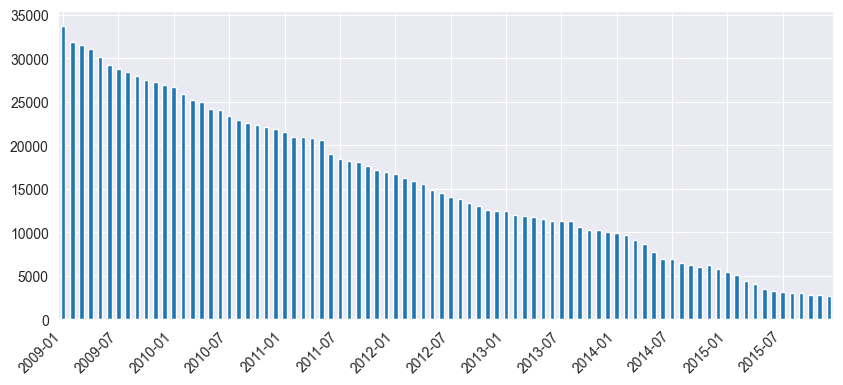

In [15]:
NumNullwithTime = cons.drop('NumNull', axis=1).isnull().sum()

sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
pbar = NumNullwithTime.plot.bar()
plt.xticks(list(range(0,len(NumNullwithTime.index),6)), list(NumNullwithTime.index[0::6]), rotation=45, ha='right')
plt.show()

* **Clasificación de los datos**

Debido al comportamiento de los valores NaN, podemos calsificar a los usuarios (filas) en tres tipos: Completos, Interrumpidos y usuarios con un inicio tardio o un fin prematuro en 
el consumo.
Para la clasificación de los usuarios se tomaron encuenta solo los valores NaN dentro de los días de servicio, es decir se toman en cuenta solo los NaN dentro del intervalo
de datos desde el primer dato diferente de NaN hasta el último diferente de NaN.

El objetivo de la clasificación es descartar datos NaN debidos a un comienzo tardio en el consumo o un final prematuro en el consumo, y de esta forma solo imputar los NaN "injustificados"
es decir los datos registrados como NaN dentro de un periodo en el que se deberia estar consumiendo.

In [16]:

groupnull = aguah.iloc[:,0:5]
groupnull = pd.concat([groupnull, cons], axis=1)

groupnull['FirstNonNull'] = cons.copy().drop(['NumNull'], axis=1).isnull().apply(FirstNonNull,axis=1)
groupnull['LastNonNull'] = cons.copy().drop(['NumNull'],axis=1).isnull().apply(LastNonNull,axis=1)
groupnull['NullInService'] = groupnull.NumNull - groupnull.FirstNonNull - (len(cons.columns)-1-groupnull.LastNonNull) +1    
groupnull['NullInService'] = groupnull['NullInService'].apply(Setzero)
groupnull.NullInService.value_counts(sort=False).head(6) ## Print only head values

NullInService
0     173773
1       3894
2        489
3        197
4         80
75         1
Name: count, dtype: int64

In [17]:
contLong = groupnull[groupnull.NumNull==0]
contShort = groupnull[(groupnull.NumNull>0) & (groupnull.NullInService==0)]
interupted = groupnull[(groupnull.NullInService)>0]
print('Length of 3 groups: (Non-NA Group, Edge-NA Group, Interupted Group) = ({}, {}, {})'.format(len(contLong), len(contShort), len(interupted)))

Length of 3 groups: (Non-NA Group, Edge-NA Group, Interupted Group) = (141205, 32568, 4824)


---

### Preparación de los datos


* **Imputación usando KNN**

In [16]:
## For KNN, choose the size of sample table (same as missing_rate above)
rng = np.random.RandomState(0)
samp_rate = 0.01  ## Here, 1 for use the whole set of entries to search (0.01 only for display)

## Prepare a reference set within Non-NA Group 
num_total = len(contLong)
num_samp = int(np.floor(samp_rate*num_total))
rand_samp = np.hstack((np.zeros(num_total-num_samp, dtype=np.bool), np.ones(num_samp, dtype=np.bool)))
rng.shuffle(rand_samp)
sample = contLong.iloc[:,5:89][rand_samp.tolist()]

In [255]:
## KNN imputation (warning it may take a couple of minutes)
itrp = interupted.copy()[(interupted.NullInService>0) & (interupted.NullInService<6)].iloc[:,5:]
result_knn = itrp.apply(lambda x: KnnImputeInPlace(sample, x, 2), axis=1)
result_knn_head = interupted.copy()[(interupted.NullInService>0) & (interupted.NullInService<6)].iloc[:,0:5]
result_knn = pd.concat([result_knn_head, result_knn],axis=1)
result_knn.shape

c:\Users\Sachistein\Proyecto_MN\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\3766263739.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp.append(sample.iloc[n_ones[1][0][j]][x_mask_toggled][n])
C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\3766263739.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp.append(sample.iloc[n_ones[1][0][j]][x_mask_toggled][n])
c:\Users\Sachistein\Proyecto_MN\env\Lib\site-packages\sklear

(4705, 93)

In [258]:
## Linear imputation 
itrp = interupted.copy()[(interupted.NullInService>5) & (interupted.NullInService<84)].iloc[:,5:]
itrp.interpolate(method='linear', axis=1, inplace=True)
result_fill_head = interupted.copy()[(interupted.NullInService>5) & (interupted.NullInService<84)].iloc[:,0:5]
result_fill = pd.concat([result_fill_head, itrp],axis=1)
result_fill.shape

(119, 93)

In [259]:
result = pd.concat([contLong, contShort, result_knn, result_fill])
result = result.iloc[:,:89]
result.shape

(178597, 89)

In [261]:
result.to_csv('datos_imputados_KNN')

* **Serie de tiempo con los datos imputados**

Con los datos imputados, graficamos el consumo con respecto al tiempo.

In [18]:
df_datos_imputados = pd.read_csv('datos_imputados_KNN.csv')
df_temp = df_datos_imputados.iloc[0:, 6:]
df_temp

2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  \
0          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
1          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
2          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
3          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
4          30.0     10.0     30.0     20.0     30.0     30.0     30.0   
...         ...      ...      ...      ...      ...      ...      ...   
178592      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
178593      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
178594     15.0     15.0     15.0     15.0     15.0     15.0     15.0   
178595      NaN      NaN      NaN      NaN      0.0      0.0      0.0   
178596     30.0     30.0     30.0     30.0     30.0     30.0     30.0   

        2009-08  2009-09  2009-10  ...    2015-03    2015-04    2015-05  \
0          20.0     20.0     20.0  ...   2.000000   1.000000   2.000000   
1          20.0     20.0     20.0  ...  27.000000  27.000000  27.000000   
2          17.0     14.0     10.0  ...  19.000000  19.000000  18.000000   
3          20.0     20.0     20.0  ...  17.000000  17.000000  17.000000   
4          30.0     30.0     30.0  ...  14.000000  15.000000  26.000000   
...         ...      ...      ...  ...        ...        ...        ...   
178592      NaN      NaN      NaN  ...  17.000000  30.000000  28.000000   
178593      NaN      NaN      NaN  ...   0.000000  48.000000   9.000000   
178594     15.0     15.0     15.0  ...  40.789474  41.710526  42.631579   
178595      0.0      0.0      0.0  ...   7.000000  12.000000   9.000000   
178596     30.0     30.0     30.0  ...  34.526316  35.473684  36.421053   

          2015-06    2015-07    2015-08    2015-09    2015-10    2015-11  \
0        1.000000   7.000000   7.000000  42.000000  27.000000  22.000000   
1       28.000000  28.000000  31.000000  27.000000  27.000000  27.000000   
2       18.000000  19.000000  19.000000  19.000000  18.000000  18.000000   
3       17.000000  17.000000  17.000000  17.000000  17.000000  17.000000   
4       27.000000  29.000000  22.000000  27.000000  26.000000  33.000000   
...           ...        ...        ...        ...        ...        ...   
178592  26.000000  16.000000  34.000000  23.000000  21.000000  31.000000   
178593  43.000000  42.000000  43.000000  41.000000  36.000000  32.000000   
178594  43.552632  44.473684  45.394737  46.315789  47.236842  48.157895   
178595   9.000000  12.000000  10.000000   9.000000   8.000000  12.000000   
178596  37.368421  38.315789  39.263158  40.210526  41.157895  42.105263   

          2015-12  
0       21.000000  
1       24.000000  
2       24.000000  
3       24.000000  
4       32.000000  
...           ...  
178592  20.000000  
178593  16.000000  
178594  49.078947  
178595   8.000000  
178596  43.052632  

[178597 rows x 84 columns]

In [19]:
df_temp = df_datos_imputados.melt(var_name='Fecha', value_name='Consumo')
df_temp['Fecha'] = pd.to_datetime(df_temp['Fecha'], format='%Y-%m', errors='coerce')
df_long = df_temp.groupby('Fecha')['Consumo'].sum().reset_index()
df_consumo_total = df_long.copy()
df_consumo_total['Fecha'] = pd.to_datetime(df_consumo_total['Fecha'])
df_consumo_total

Fecha          Consumo
0  2009-01-01        9372506.5
1  2009-02-01   7029116.263158
2  2009-03-01   5568504.276316
3  2009-04-01   6150863.857656
4  2009-05-01   6865531.522545
..        ...              ...
79 2015-08-01  17799041.328627
80 2015-09-01  19535532.662902
81 2015-10-01  10923627.997176
82 2015-11-01  15185690.331451
83 2015-12-01  14030023.665725

[84 rows x 2 columns]

* **Normalización de los datos**

Ya con los datos imputados, se procedió a normalizarlos.

In [20]:
scaler = MinMaxScaler()
df_normalizado = df_consumo_total.copy()
df_normalizado['Consumo_normalizado'] = scaler.fit_transform(df_consumo_total[['Consumo']])
df_normalizado

Fecha          Consumo  Consumo_normalizado
0  2009-01-01        9372506.5             0.398235
1  2009-02-01   7029116.263158             0.263232
2  2009-03-01   5568504.276316             0.179086
3  2009-04-01   6150863.857656             0.212636
4  2009-05-01   6865531.522545             0.253808
..        ...              ...                  ...
79 2015-08-01  17799041.328627             0.883689
80 2015-09-01  19535532.662902             0.983729
81 2015-10-01  10923627.997176             0.487596
82 2015-11-01  15185690.331451             0.733134
83 2015-12-01  14030023.665725             0.666556

[84 rows x 3 columns]

In [21]:
df_normalizado.drop('Consumo', axis=1, inplace=True)
df_normalizado.rename(columns={'Consumo_normalizado':'Consumo'}, inplace=True)
df_normalizado.set_index('Fecha', inplace=True)
df_normalizado

Consumo
Fecha               
2009-01-01  0.398235
2009-02-01  0.263232
2009-03-01  0.179086
2009-04-01  0.212636
2009-05-01  0.253808
...              ...
2015-08-01  0.883689
2015-09-01  0.983729
2015-10-01  0.487596
2015-11-01  0.733134
2015-12-01  0.666556

[84 rows x 1 columns]

<Axes: title={'center': 'Serie de Consumo Normalizado por Fecha'}, xlabel='Fecha'>

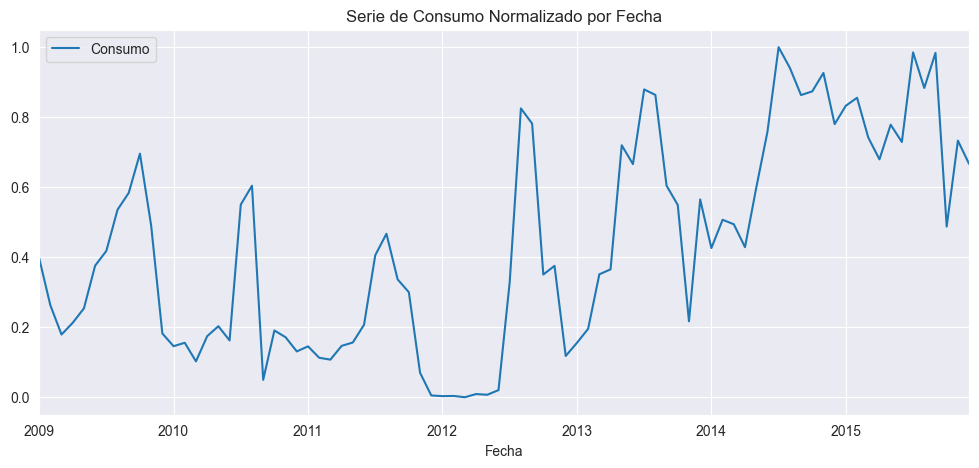

In [22]:
df_normalizado.plot(title="Serie de Consumo Normalizado por Fecha", figsize=(12,5))

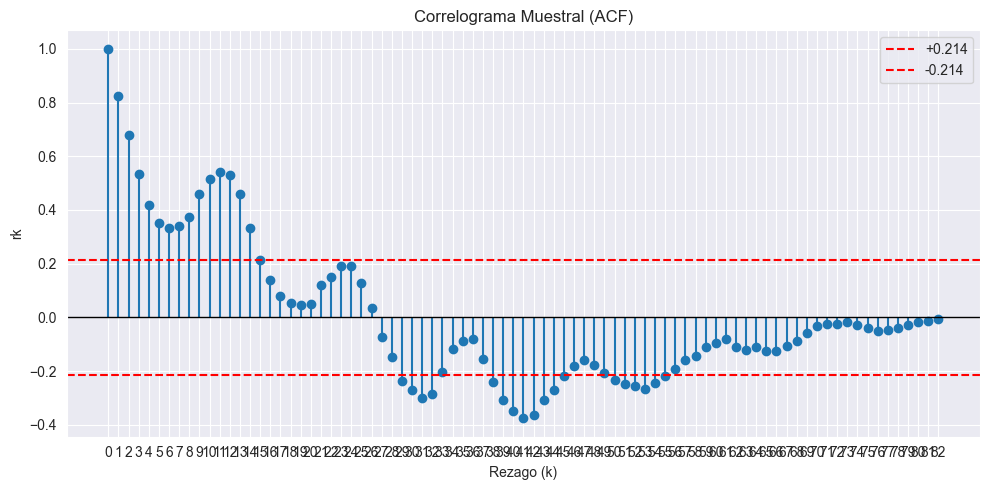

In [63]:
rk = coeficientes_rk(df_normalizado, 83)

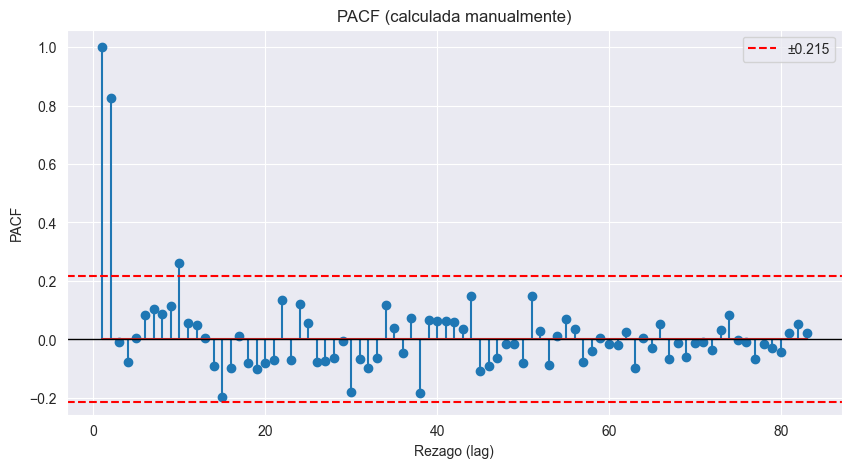

In [68]:
pacf, phi = levinson_durbin(rk)

mean       std
Año                     
2009  0.382410  0.169673
2010  0.220049  0.172226
2011  0.204971  0.141680
2012  0.235213  0.303713
2013  0.510989  0.252315
2014  0.716391  0.213533
2015  0.779820  0.140623

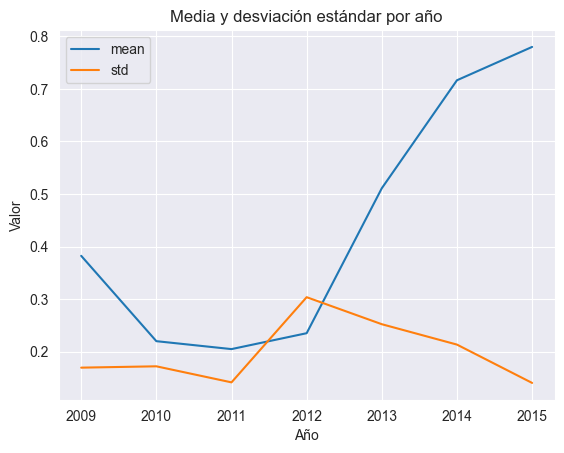

In [69]:
calcular_estadisticas(df_normalizado)

---

## Modelamiento con método Box-Jenkins

In [70]:
df_normalizado.to_csv("consumo_total.csv", index = True)

mean       std
Año                     
2010 -0.162361  0.209329
2011 -0.015078  0.122231
2012  0.030243  0.223588
2013  0.275776  0.289788
2014  0.205402  0.203335
2015  0.063428  0.236251

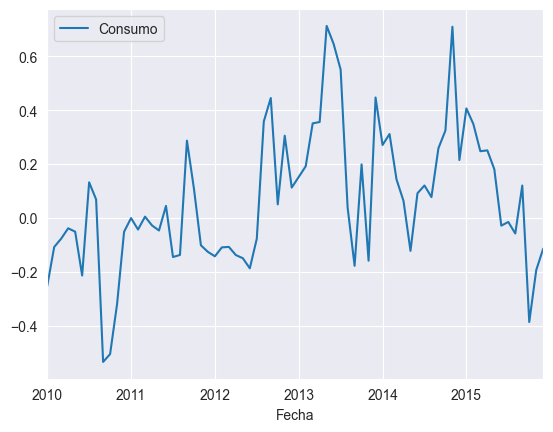

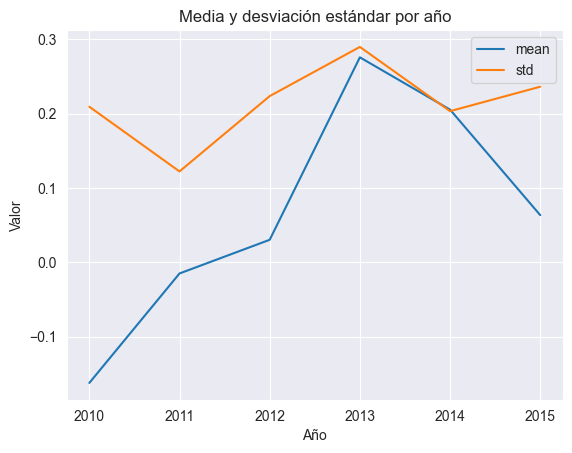

In [71]:
df_dif_1 = diferenciar(df_normalizado)
graficar(df_dif_1)
calcular_estadisticas(df_dif_1)

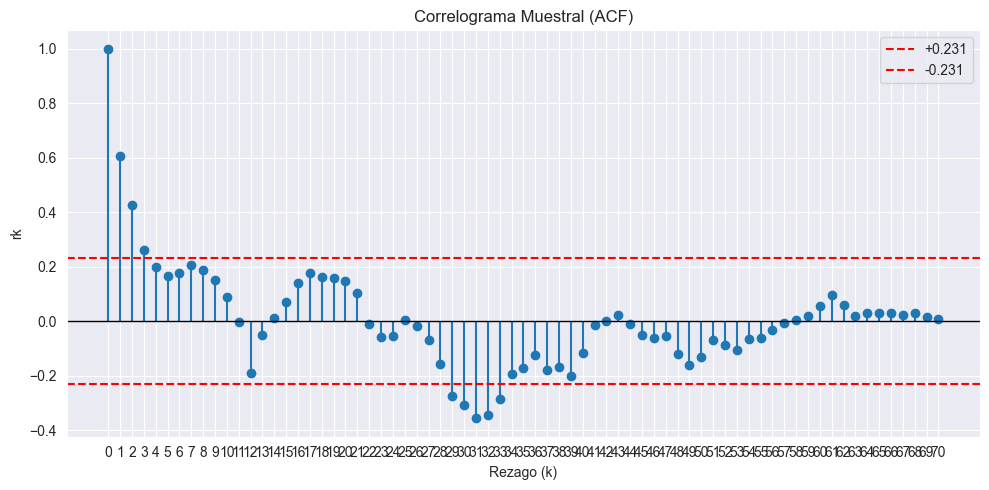

In [72]:
rk = coeficientes_rk(df_dif_1, 71)

Se decidió probar con 4 rezagos ya que en la ACF son los 4 primeros rezagos los que sobrepazan el intervalo de confianza.
Es decir, son estadísticamente confiablez al 95%.

Los resultados de esta gráfica nos dan un muy buen idício de usar un coeficiente $p = 4$ es decir un modelo $AR(4)$.

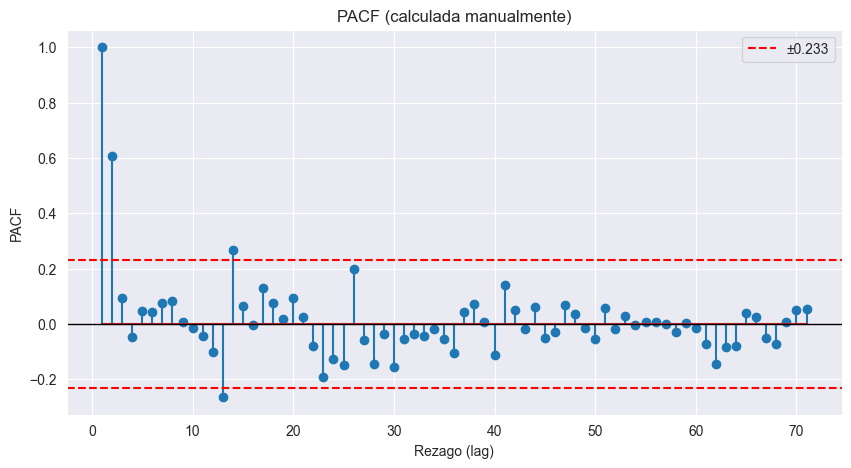

In [74]:
pacf, phi = levinson_durbin(rk)

El resultado de la PACF, nos indica que un modelo autoregresivo de orden 2 (ya que son los primeros dos resultados de la pacf los que salen del intervalo de confianza) es suficiente para modelar nuestra linea de tiempo. Es decri, que para el modelado se utilizará un modelo AR(2).

---

## Función de autocorrelación estimada

$$
r_k
=
\frac{\sum^T_{t =k+1} (x_t - \hat{x}) (x_{t-k} - \hat{x})}{\sum^T_{t = 1} (x_t - \hat{x})^2}
$$

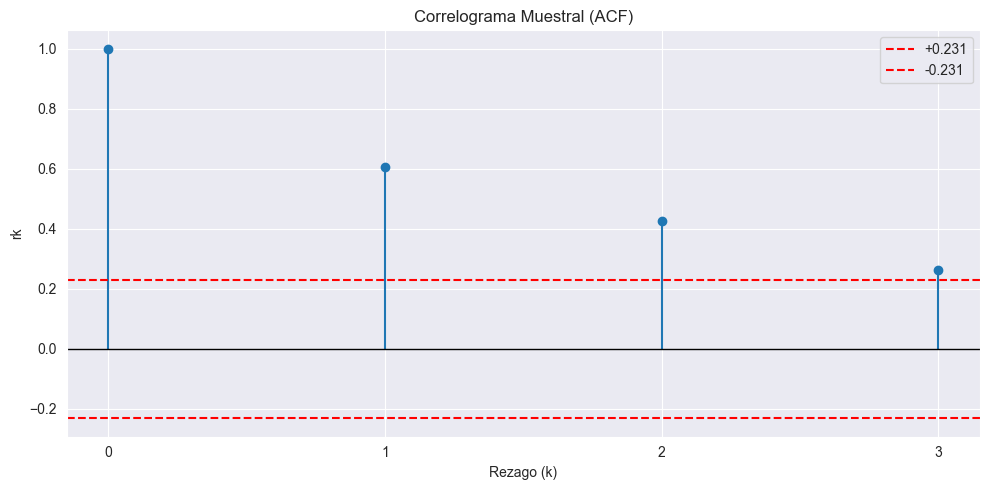

[1.         0.60669578 0.42772633 0.26258746]


In [75]:
rk = coeficientes_rk(df_dif_1,4)
print(rk)


$$
r_k 
=
\left(
\begin{array}{c}
1.0 \\
0.60669578 \\
0.42772633 \\
0.26258746 \\
\end{array}
\right)
$$

---

### Función de autocorrelación parcial (PACF)

* **Algoritmo de Leivinson-Durbin**

El algoritmo de Leivinson-Durbin es un procedimiento que nos permite estimar los coeficientes para un modlo autoregresivo $AR(k)$.
También estima el coeficiente $\phi_{kk}$, que este mismo es la PACF en el rezago $k$.

$$
\phi_{kk}
=
\left(
\begin{array}{ccc}
\phi_{11} & 0 & 0\\
\phi_{21} &  \phi_{22}& 0\\
\phi_{31} &  \phi_{32}& \phi_{33}\\
\end{array}
\right)
$$

Como antes calculamos los coeficientes de autocorrelación $r_k$ podemos asumir por propiedad que el primer valor de $\phi_{kk}$ es igual a el primer valor de $r_k$.

Es decir:

$$
\phi_{11}
=
r_1
=
0.60669578
$$

Para los siguientes valores de $\phi_{kk}$ se aplicó el algoritmo de Leivinson-Durbin.
Dado una serie de autocorrelaciones, es decir $r_k$, desde $k=1$ aplicamos el paso recursivo.

Paso recursivo para $k \geq 2$:

$$
\phi_{kk}
=
\frac{r_k - \sum_{j=1}^{k-1} \phi_{k-1,j}r_{k-j}}{\sigma^2_{k-1}}
$$

Actualización de los coeficientes, para $j = 1, \dots, k-1$:

$$
\phi_{k,j} = \phi_{k,j} - \phi_{kk}\phi_{k-1,k-j}
$$

Actualizacón de varianza:

$$
\sigma^2_k = \sigma^2_{k-1} (1 - \phi^2_{kk})
$$

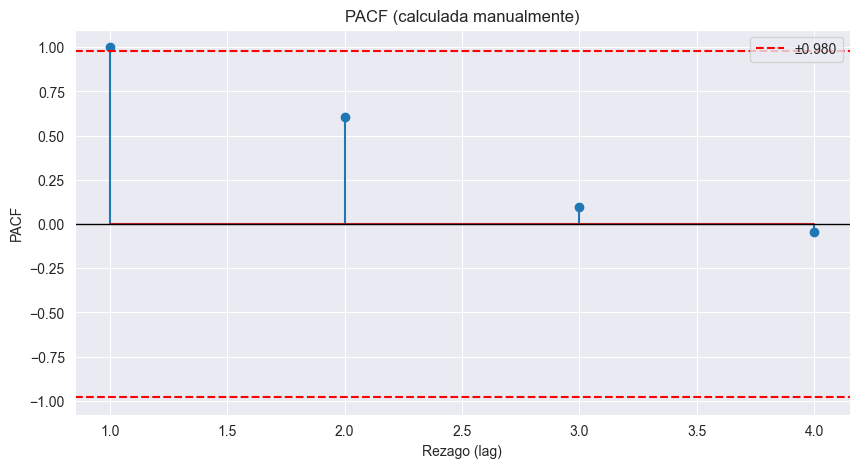

In [77]:
pacf, phi = levinson_durbin(rk)


In [78]:
phi

array([[ 0.60669578,  0.        ,  0.        ],
       [ 0.54943014,  0.09438939,  0.        ],
       [ 0.55390386,  0.12043042, -0.04739643]])

$$
\phi_{kk}
=
\left(
\begin{array}{ccc}
\textbf{ 0.60669578} & 0 & 0\\
0.54943014 &  \textbf{0.09438939}& 0\\
0.55390386 &  0.12043042& \textbf{-0.04739643}\
\end{array}
\right)
$$

In [79]:
pacf

array([ 1.        ,  0.60669578,  0.09438939, -0.04739643])

---

### Modelado

Para el modelado usamos los coeficientes $\phi_{pk}$ correspondientes al orden del modelo $AR(p)$ que vayamos a implementar. Es decir, si deseamos implementar un modelo $AR(1)$ tomamos los valores de $\phi_{1k}$. 

* **AR(1)**

$$
\phi_{1} = 0.60669578
$$

$$
\hat{z}_t = 0.60669578 y_{t-1}
$$

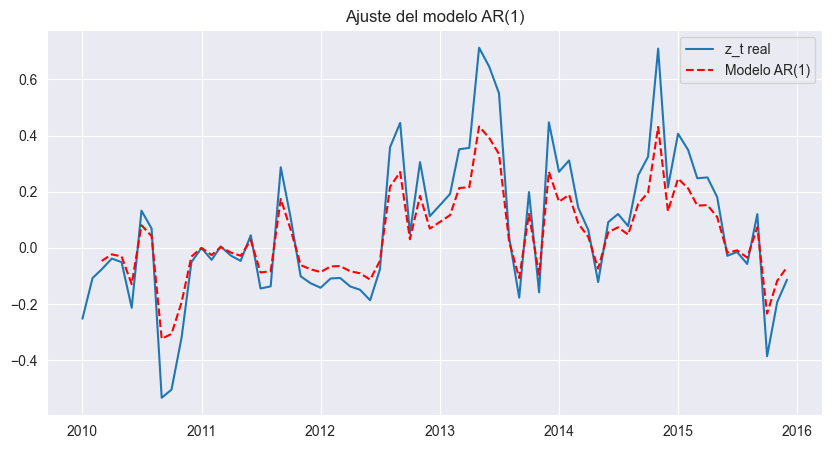

In [88]:
phi_1 = 0.60669578

z_modelo = modelo_ar1(df_dif_1['Consumo'], phi_1)

plt.figure(figsize=(10, 5))
plt.plot(df_dif_1['Consumo'], label='z_t real')
plt.plot(z_modelo,color='red', label='Modelo AR(1)', linestyle='--')
plt.title("Ajuste del modelo AR(1)")
plt.legend()
plt.grid(True)
plt.show()
#GPT: -0.277428

* **AR(2)**

$$
\phi_1 =  0.54943014,\quad \phi_2 = 0.09438939
$$

$$
\hat{z}_t = 0.54943014 y_{t-1} + 0.09438939 y_{t-2}
$$

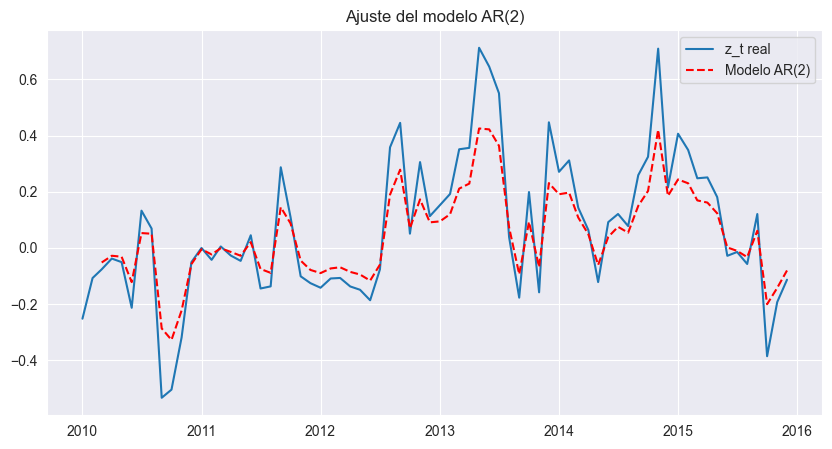

In [86]:
phi_1 = 0.5494301
phi_2 = 0.09438939

z_modelo = modelo_ar2(df_dif_1['Consumo'], phi_1, phi_2 )

plt.figure(figsize=(10, 5))
plt.plot(df_dif_1['Consumo'], label='z_t real')
plt.plot(z_modelo,color='red', label='Modelo AR(2)', linestyle='--')
plt.title("Ajuste del modelo AR(2)")
plt.legend()
plt.grid(True)
plt.show()

#Chatgpt : -0.311167, -0.11257914

* **AR(3)**

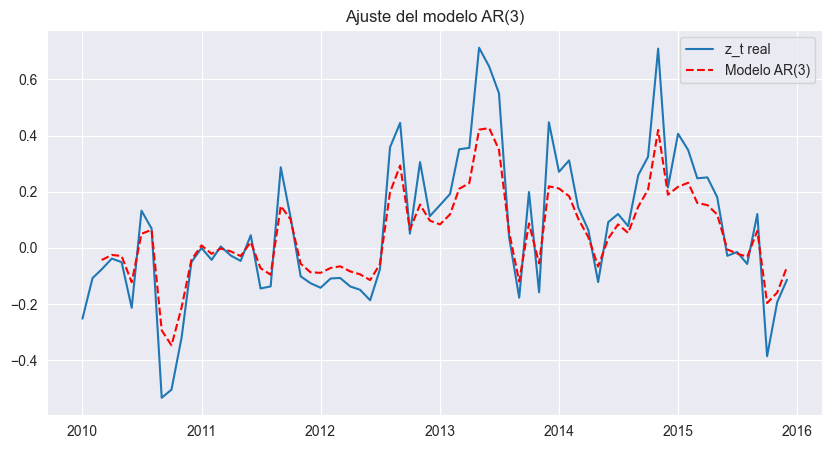

In [87]:
phi_1 = 0.55390386
phi_2 = 0.12043042
phi_3 = -0.04739643

z_modelo = modelo_ar3(df_dif_1['Consumo'], phi_1, phi_2, phi_3)

plt.figure(figsize=(10, 5))
plt.plot(df_dif_1['Consumo'], label='z_t real')
plt.plot(z_modelo,color='red', label='Modelo AR(3)', linestyle='--')
plt.title("Ajuste del modelo AR(3)")
plt.legend()
plt.grid(True)
plt.show()

Se decidió usar el modelo $AR(1)$ ya que es el que mejor se ajusta a la gráfica original.

---

### Pronóstico

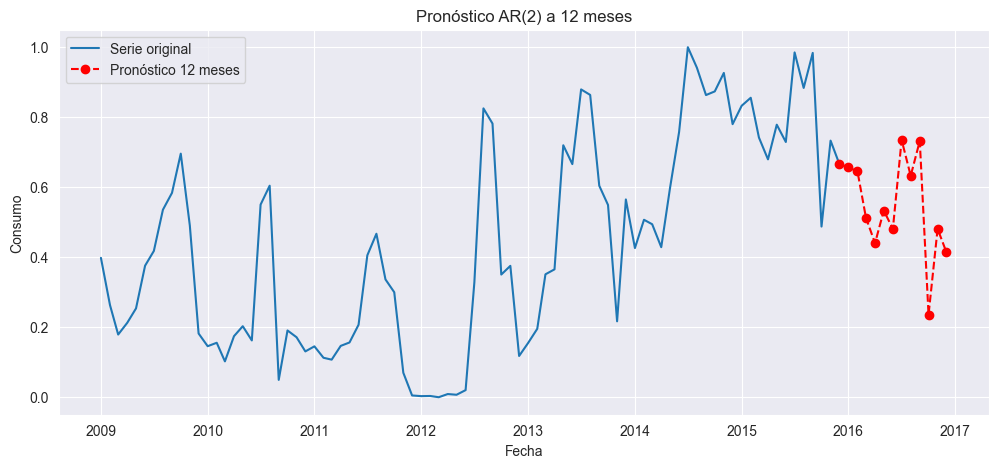

In [89]:
phi_1 = 0.54943014
df_extendido, y_preds = pronosticar_ar1(df_dif_1, df_normalizado, phi_1, pasos=12)

plt.figure(figsize=(12, 5))
plt.plot(df_normalizado['Consumo'], label='Serie original')
plt.plot(df_extendido.index[-13:], df_extendido['Consumo'].iloc[-13:], 'ro--', label='Pronóstico 12 meses')
plt.title("Pronóstico AR(2) a 12 meses")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.grid(True)
plt.legend()
plt.show()



---

### Simulación

In [43]:
def simular_ar1(phi_1, sigma, pasos, impacto=-0.2, desde_mes=6,
                                   z_inicial=0, y_inicial=None, semilla=42):
    """
    Simula una serie AR(1) con impacto de sequía y reconstruye los valores originales y_t.

    Parámetros:
    - phi_1: coeficiente AR(1)
    - sigma: desviación estándar del ruido
    - pasos: meses a simular
    - impacto: porcentaje de reducción a partir de cierto mes
    - desde_mes: mes en que inicia la sequía
    - z_inicial: valor inicial de z
    - y_inicial: lista de los últimos 13 valores reales de y (necesario)
    - semilla: para reproducibilidad

    Retorna:
    - z_sim: valores simulados diferenciados
    - y_sim: valores reconstruidos en la escala original
    """
    if y_inicial is None or len(y_inicial) < 13:
        raise ValueError("Se requieren al menos los últimos 13 valores de y_t para la reconstrucción.")

    np.random.seed(semilla)
    z_sim = np.zeros(pasos)
    z_sim[0] = z_inicial

    for t in range(1, pasos):
        ruido = np.random.normal(0, sigma)
        z_t = phi_1 * z_sim[t-1] + ruido

        if t >= desde_mes:
            z_t *= (1 + impacto)  # reducir consumo

        z_sim[t] = z_t

    # Reconstrucción de y_t
    y_sim = []
    y_hist = y_inicial.copy()

    for t in range(pasos):
        y_t = z_sim[t] + y_hist[-1] + y_hist[-12] - y_hist[-13]
        y_sim.append(y_t)
        y_hist.append(y_t)

    return z_sim, y_sim



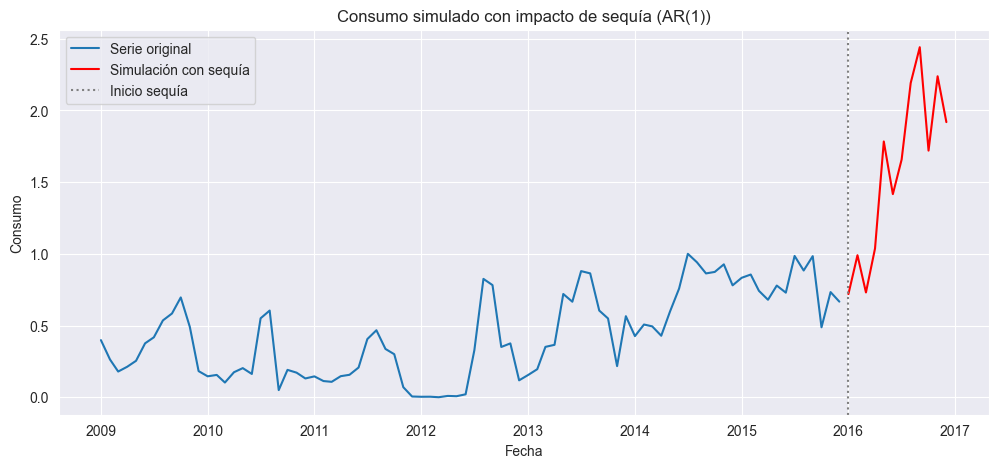

In [46]:
# Últimos 13 valores reales del consumo original
y_ultimos_13 = df_normalizado['Consumo'].iloc[-13:].tolist()

# Parámetros del modelo AR(1)
phi_1 = -0.31
sigma = 0.5

# Simular 12 meses con sequía desde el mes 6
z_sim, y_sim = simular_ar1(phi_1, sigma, pasos=12,
                                              impacto=-0.2, desde_mes=6,
                                              y_inicial=y_ultimos_13)

# Crear serie simulada con fechas
import pandas as pd
from matplotlib import pyplot as plt

fechas_sim = pd.date_range(start=df_normalizado.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
df_simulado = pd.Series(y_sim, index=fechas_sim, name='Consumo Simulado')

# Graficar junto al original
plt.figure(figsize=(12, 5))
plt.plot(df_normalizado['Consumo'], label="Serie original")
plt.plot(df_simulado, color='red',label="Simulación con sequía")
plt.axvline(fechas_sim[0], color='gray', linestyle=':', label='Inicio sequía')
plt.title("Consumo simulado con impacto de sequía (AR(1))")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.grid(True)
plt.legend()
plt.show()

